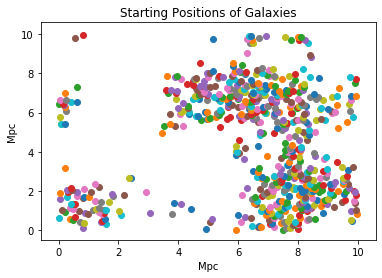

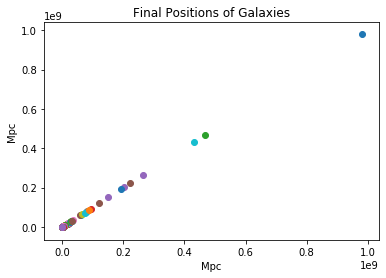

In [26]:
'''
ASTP-720, Fall 2020
Homework 5
Zach Diermyer
Problem 1
'''

import numpy as np
import matplotlib.pyplot as plt

def CoM(coords, m):
    '''
    Finds the center of mass of particles at each coordinate in the given arrays
    Inputs:
        coords - Array of [x, y] tuples/distances to each particle
        m - Integer value of particle masses
    Returns:
        comx - Center of mass x coordinate
        comy - Center of mass y coordinate
    '''
    totx = 0
    toty = 0
    totm = 0
    for i in range(len(coords)):
        totx += (m*coords[i][0])
        toty += (m*coords[i][1])
        totm += m
    comx = totx/totm
    comy = toty/totm
    return(comx, comy)

def treewalk(node, node0, thetamax, m, eps, h):
    '''
    Compares a leaf node to a branch node and if branch node is within opening angle limit
    checks deeper branch nodes.
    Inputs:
        node - Leaf node
        node0 - Branch node
        thetamax - Limiting value of opening angle
        m - Mass of each individual galaxy
        eps - Distance limit to use force softening within
        h - Step size
    Returns:
        Nothing, alters node position
    '''
    if len(node.COM[0]) < 2:
        return
    elif len(node0.COM) < 2:
        return
    dx = node.COM[0][0] - node0.COM[0]
    dy = node.COM[0][1] - node0.COM[1]
    D = np.sqrt((dx**2)+(dy**2))
    if D < node.length/thetamax:      #Inside of opening angle limit
        if D < eps:     #Inside of force softening limit
            D = 1/forcesoften(r = D, eps = eps)
            newcoords = verlet([node.COM[0], D], [node.prevCOM[0], node0.prevCOM], m, h)
            node.prevdata = node.data
            node.prevCOM = node.COM
            node.data = newcoords
            node.COM = newcoords
        elif len(node0.quads) > 1:    #Recursively move to lower branches
            for i in range(len(node0.children)):
                treewalk(node, node0.children, thetamax, m, eps, h)
        else:           #Solve by direct summation
            newcoords = verlet([node.COM[0], node0.COM], [node.prevCOM[0], node0.prevCOM], m, h)
            node.prevdata = node.data
            node.prevCOM = node.COM
            node.data = newcoords
            node.COM = newcoords
    else:             #Solve by approximation
        newcoords = verlet([node.COM[0], node0.COM], [node.prevCOM[0], node0.prevCOM], m, h)
        node.prevdata = node.data
        node.prevCOM = node.COM
        node.data = newcoords
        node.COM = newcoords
        

class Node:
    def __init__(self, data, prevdata, C, L, m, singles):
        '''
        Creates a tree by recursively building nodesusing input data
        Inputs:
            self - Node object
            data - Input data array of [x,y] coodinates
            prevdata - Input previous time step data with same type and structure as data
            C - Array of [x,y] coordinates of center of node box
            L - Integer length of node box
            m - Mass of each individual galaxy
            singles - Array of leaf nodes
        Returns:
            Nothing, creates tree and fill singles array with leaf nodes
        '''
        self.data = data
        self.prevdata = prevdata
        self.center = C
        self.length = L
        self.children = []
        Npoints = len(data)
        if Npoints == 1:        #leaf node
            self.quads = self.data
            self.COM = self.data
            self.prevCOM = self.prevdata
            self.mass = m
            singles.append(self)
        elif Npoints == 0:      #skip empty nodes
            pass
        else:
            self.quads = [[], [], [], []]
            self.prevquads = [[], [], [], []]
            self.COM = CoM(coords = self.data, m = Npoints*m)
            self.prevCOM = CoM(coords = self.prevdata, m = Npoints*m)
            self.GenerateQuads(m, singles) #recursive helper function breaks up data
            
    def GenerateQuads(self, m, singles):
        '''
        If node contains more than one data point, breaks up node box into 4 separate quadrants
        and creates child nodes out of eahc quadrant
        Inputs:
            Self - Node object
            m - Mass of each individual galaxy
            singles - Array of leaf nodes
        Returns:
            Nothing, creates child nodes
        '''
        midx = self.center[0]/2
        midy = self.center[1]/2
        newcenter = [[midx, midy], [self.center[0] + midx, midy], [self.center[0] + midx, self.center[1] + midy],\
                    [midx, self.center[1] + midy]]
        for i in range(len(self.data)):
            if self.data[i][1] < self.center[1]:
                if self.data[i][0] < self.center[0]:
                    self.quads[0].append(self.data[i])
                else:
                    self.quads[1].append(self.data[i])
            else:
                if self.data[i][0] > self.center[0]:
                    self.quads[2].append(self.data[i])
                else:
                    self.quads[3].append(self.data[i])
        for i in range(len(self.prevdata)):
            if self.prevdata[i][1] < self.center[1]:
                if self.prevdata[i][0] < self.center[0]:
                    self.prevquads[0].append(self.prevdata[i])
                else:
                    self.prevquads[1].append(self.prevdata[i])
            else:
                if self.prevdata[i][0] > self.center[0]:
                    self.prevquads[2].append(self.prevdata[i])
                else:
                    self.prevquads[3].append(self.prevdata[i])
        for j in range(len(self.quads)):
            self.children.append(Node(data = self.quads[j], prevdata = self.prevquads[j], \
                                      C = newcenter[j], L = self.length/2, m = m, singles = singles))

def verlet(coords, prevcoords, m, h):
    '''
    Uses the Verlet algorithm for symplectic integration of particle motion
    Inputs:
        coords - Array of [x, y] tuples/distances to each particle
        prevcoords - Array of [x, y] tuples/distances to each particle in the previous step
        m - Integer value of particle masses
        h - Step size
    Returns:
        newcoords - Array of [x, y] tuples/distances to each particle after integration
    '''
    G = 4.30091e-3     #In solar units
    a = []
    for i in range(len(coords)):
        aix = 0
        aiy = 0
        for j in range(len(coords)):
            if j == i:
                pass
            else:
                diffx = coords[i][0]-coords[j][0]
                diffy = coords[i][1]-coords[j][1]
                aix += G*m*(diffx/(diffx**3))
                aiy += G*m*(diffy/(diffy**3))
        a.append([aix, aiy])
    newcoords = []
    for i in range(len(coords)):
        xi1 = 2*coords[i][0] - prevcoords[i][0] + (h**2)*(a[i][0])
        yi1 = 2*coords[i][1] - prevcoords[i][1] + (h**2)*(a[i][1])
        newcoords.append([xi1, yi1])
    return(newcoords)

def forcesoften(r, eps):
    '''
    Uses the force softening equation to alter distance of very close objects
    Inputs:
        r - Distance between objects
        eps - Distance limit to start use force softening
    Returns:
        s - Updated distance
    '''
    s = -1/((r**2 + eps**2)**(1/2))
    return(s)

def main():
    start = np.load('galaxies0.npy')
    step1 = np.load('galaxies1.npy')
    plt.figure(1)
    for i in range(len(start)):
        plt.scatter(x = start[i][0], y = start[i][1])
    plt.xlabel('Mpc')
    plt.ylabel('Mpc')
    plt.title('Starting Positions of Galaxies')
    count = 1
    singles = []
    tree = Node(data = step1, prevdata = start, L = 10, C = [5, 5], m = 10e12, singles = singles)
    count = 1
    for i in range(len(singles)):
        for j in range(len(tree.children)):
            treewalk(singles[i], node0 = tree.children[j], thetamax = 1, m = 10e12, eps = 1e-4, h = 0.001)
    plt.figure(2)
    for i in range(len(singles)):
        plt.scatter(x = singles[i].data[0], y = singles[i].data[0])
    plt.xlabel('Mpc')
    plt.ylabel('Mpc')
    plt.title('Final Positions of Galaxies')  
        
main()


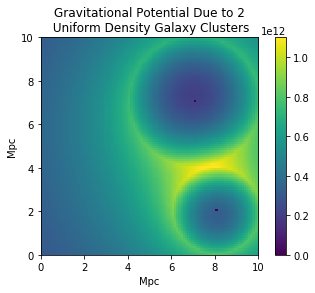

In [20]:
'''
ASTP-720, Fall 2020
Homework 5
Zach Diermyer
Problem 2
'''

import numpy as np
import matplotlib.pyplot as plt

def calcpotential(x, y, rad1, rad2, center1, center2):
    '''
    Calculates the center of mass of the point at the given x,y coordinate using
    the given radii and centers
    Inputs:
        x - x coordinate of potential calculation
        y - y coordinate of potential calculation
        rad1 - Radius of the first galaxy cluster
        rad2 - Radius of the second galaxy cluster
        center1 - x,y coordinates of the first cluster center
        center2 - x,y coordinates of the second cluster center
    Returns:
        phi1+phi2 - Total gravitational potential at the desired point
    '''
    G = 4.30091e-3     #In solar units
    M1 = 400*10e12
    M2 = 255*10e12
    V01 = (4/3)*np.pi*rad1**3
    V02 = (4/3)*np.pi*rad2**3
    dist1 = (((x-center1[0])**2)+((y-center1[1])**2))**(1/2)
    dist2 = (((x-center2[0])**2)+((y-center2[1])**2))**(1/2)
    if dist1 <= rad1:
        V1 = (4/3)*np.pi*dist1**3
        V2 = (4/3)*np.pi*rad2**3
    elif dist2 <= rad2:
        V1 = (4/3)*np.pi*rad1**3
        V2 = (4/3)*np.pi*dist2**3
    else:
        V1 = (4/3)*np.pi*rad1**3
        V2 = (4/3)*np.pi*rad2**3
    menc1 = (V1/V01)*M1
    menc2 = (V2/V02)*M2
    phi1 = G*menc1/dist1
    phi2 = G*menc2/dist2
    return(phi1+phi2)

def main():
    potential = []
    rad1 = 30
    center1 = [70, 70]
    rad2 = 20
    center2 = [80, 20]
    for i in range(0, 100):
        potential.append([])
        for j in range(0, 100):
            if i == center1[1] and j == center1[0]:
                potential[i].append(0)
            elif i == center2[1] and j == center2[0]:
                potential[i].append(0)
            else:
                potential[i].append(calcpotential(j, i, rad1, rad2, center1, center2))
    plt.imshow(potential, origin = 'lower', extent = [0, 10, 0, 10])
    plt.xlabel('Mpc')
    plt.ylabel('Mpc')
    plt.title('Gravitational Potential Due to 2\n Uniform Density Galaxy Clusters')
    plt.colorbar()
    
main()